In [2]:
MODEL_PATH      = "SAM_models/sam_vit_b_01ec64.pth"
IMAGE_PATH      = "Images/Original_Img.jpg"
STROKES_PATH    = "Images/Strokes.json" 
TREND_PATH      = "Images/Trend.jpg"
SAM_PATH        = "Images/SAM_Img.jpg"

import  numpy as np
import  cv2
import  matplotlib.pyplot as plt
import  json
import  csv
import  pandas as pd
from    segment_anything import sam_model_registry, SamAutomaticMaskGenerator
from    skimage.measure import label
from    matplotlib.patches import Patch

In [3]:
# Procedure 

In [4]:
# Step 1: Full image automatic masks detection

# Load SAM Model - using the ViT-B SAM model 
DEVICE = "cpu" 
sam    = sam_model_registry["vit_b"](checkpoint=MODEL_PATH).to(DEVICE)

# Create an automatic mask generator 
mask_generator = SamAutomaticMaskGenerator(
    sam,
    points_per_side         = 16,  
    pred_iou_thresh         = 0.85, 
    stability_score_thresh  = 0.9,
    min_mask_region_area    = 1000
)

# Load and prepare an image - BGR to RGB
image = cv2.imread(IMAGE_PATH)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Generate masks
masks = mask_generator.generate(image)

In [5]:
# Step 2: User mask-processing

img_height, img_width   = image.shape[:2]

print(f"[INFO] Loaded image: {IMAGE_PATH}")
print(f"[INFO] Image size: height={img_height}, width={img_width}")

# Prepare blank mask
user_mask = np.zeros((img_height, img_width), dtype=np.uint8)

# Load strokes
with open(STROKES_PATH, "r") as f:
    strokes_data = json.load(f)

# Draw strokes on mask
for stroke in strokes_data:
    points = np.array([[int(p["x"]), int(p["y"])] for p in stroke["points"]], dtype=np.int32)
    points = points.reshape((-1, 1, 2))
    cv2.fillPoly(user_mask, [points], color=1)

# Optionally fill
user_mask = cv2.dilate(user_mask, np.ones((3, 3), np.uint8), iterations=1)
user_mask = cv2.morphologyEx(user_mask, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8))
user_mask = (user_mask > 0).astype(np.uint8)

print(f"[INFO] User mask size: {user_mask.shape}")
print(f"[INFO] User mask non-zero pixels: {np.count_nonzero(user_mask)}")

[INFO] Loaded image: Images/Original_Img.jpg
[INFO] Image size: height=1536, width=2048
[INFO] User mask size: (1536, 2048)
[INFO] User mask non-zero pixels: 171959


In [6]:
def compute_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return intersection / union if union > 0 else 0.0

In [7]:
# Step 3: User masks vs SAM Segmentation

combined_user_mask  = np.zeros_like(user_mask)
combined_sam_mask   = np.zeros_like(user_mask)
ious                = []
user_labeled        = label(user_mask)  # This gives labels like 0,1,2,3 (0 is background)
num_regions         = np.max(user_labeled)
user_masks          = [(user_labeled == i).astype(np.uint8) for i in range(1, num_regions + 1)]
print(f"[INFO] Found {num_regions} user-defined regions.")

# Convert all SAM masks to binary masks
sam_binary_masks = [m["segmentation"].astype(np.uint8) for m in masks]

for i, u_mask in enumerate(user_masks):
    best_iou = 0
    best_idx = -1
    for j, s_mask in enumerate(sam_binary_masks):
        # Resize if needed
        if s_mask.shape != u_mask.shape:
            s_mask = cv2.resize(s_mask, (u_mask.shape[1], u_mask.shape[0]), interpolation=cv2.INTER_NEAREST)

        iou = compute_iou(u_mask, s_mask)
        if iou > best_iou:
            best_iou = iou
            best_idx = j

    best_sam = sam_binary_masks[best_idx]
    combined_user_mask = np.logical_or(combined_user_mask, u_mask)
    combined_sam_mask = np.logical_or(combined_sam_mask, best_sam)
    ious.append(best_iou)

avg_iou = sum(ious) / len(ious)
print(f"[INFO] Average IoU: {avg_iou:.4f}")

[INFO] Found 2 user-defined regions.
[INFO] Average IoU: 0.4868


In [8]:
with open("iou_results.csv", "a", newline="") as f:
    writer = csv.writer(f)
    writer.writerow([avg_iou])

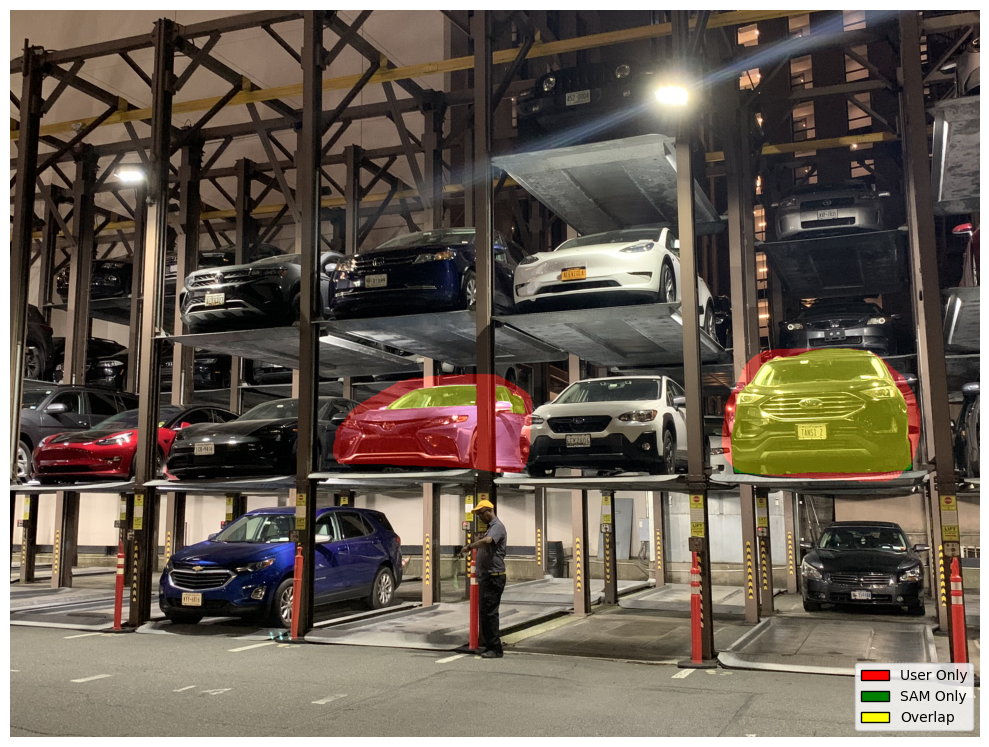

In [9]:
# Step 4: Create visualization

# Red = User only, Green = SAM only, Yellow = overlap
user_only = np.logical_and(combined_user_mask == 1, combined_sam_mask == 0)
sam_only  = np.logical_and(combined_user_mask == 0, combined_sam_mask == 1)
both      = np.logical_and(combined_user_mask == 1, combined_sam_mask == 1)

overlay_mask = np.zeros_like(image)
overlay_mask[user_only] = [255, 0, 0]     # Red
overlay_mask[sam_only]  = [0, 255, 0]     # Green
overlay_mask[both]      = [255, 255, 0]   # Yellow

# Blend with original image
alpha = 0.4
final_overlay = cv2.addWeighted(image, 1.0, overlay_mask, alpha, 0)
plt.figure(figsize=(10, 8))
plt.imshow(final_overlay)
plt.axis("off")

# Add legend
legend_elements = [
    Patch(facecolor='red',   edgecolor='black', label='User Only'),
    Patch(facecolor='green', edgecolor='black', label='SAM Only'),
    Patch(facecolor='yellow',edgecolor='black', label='Overlap'),
]
plt.legend(handles=legend_elements, loc='lower right', fontsize=10)

plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.tight_layout()
plt.savefig(SAM_PATH, bbox_inches='tight', pad_inches=0)
plt.show()

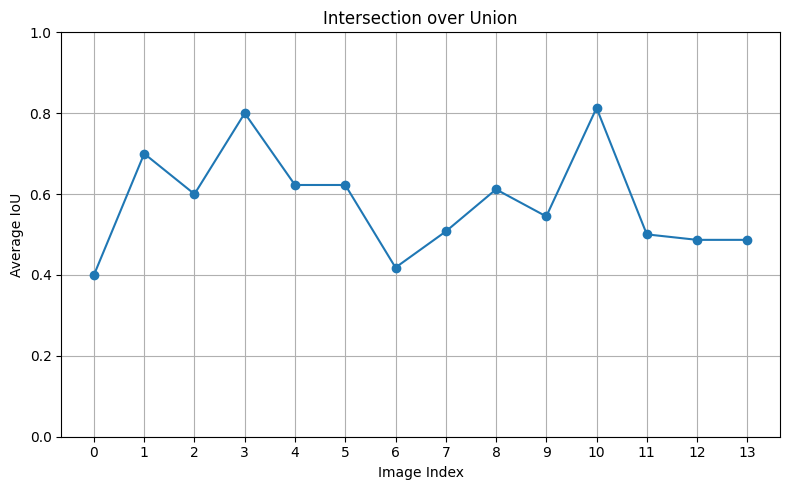

In [10]:
# Trend visualization
df = pd.read_csv("iou_results.csv", header=None, names=["avg_iou"])

# Plot it
plt.figure(figsize=(8, 5))
plt.plot(range(len(df)), df["avg_iou"], marker='o', linestyle='-')
plt.title("Intersection over Union")
plt.xlabel("Image Index")
plt.ylabel("Average IoU")
plt.ylim(0, 1)
plt.xticks(range(len(df))) 
plt.grid(True)
plt.tight_layout()
plt.savefig(TREND_PATH)
plt.show()
